# Global Prediction and Generation of Figure 4 Panels

This notebook runs ridge regressions on the pre-featurized global data matrix using a 5-fold cross-validation approach for the four labels for which we have global data: forest cover, nighttime lights, elevation, and population density.

1. It first does so using a single global regression model (not shown in Fig 4.)
2. It then runs separate models for each geographical region (roughly at the continent scale).
3. It then applies the weights learned in the model in (2) to densely sampled regions of images.

## Settings

Here are the settings you can adjust when running this notebook:
- ``num_threads``: If running on a multi-core machine, change this from ``None`` to an ``int`` in order to set the max number of threads to use
- ``subset_[n,feat]``: If you want to subset the training set data for quick tests/debugging, specify that here using the `slice` object. `slice(None)` implies no subsetting of the ~80k observations for each label that are in the training set. `subset_n` slices observations; `subset_feat` subsets features.
- ``labels_to_run``: By default, this notebook will loop through the four labels we have available at the global scale. If you would like, you can reduce this list to only loop through a subset of them.
- ``fixed_lambda``: If True, only run the lambda that was previously chosen. Will throw an error if you haven't already generated a results file.

In [1]:
num_threads = None

subset_n = slice(None)
subset_feat = slice(None)

# only running 4 labels as global predictions: adjust if you'd like to run a subset of these
labels_to_run = ["treecover", "elevation", "population", "nightlights"]

fixed_lambda = False

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import io as b_io
import os
from pathlib import Path

import dill

from cartopy import crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from matplotlib.axes import Axes
from mosaiks import transforms
from mosaiks.plotting import plot_world as pw
from mosaiks.utils.imports import *
from threadpoolctl import threadpool_limits

# set values
if num_threads is not None:
    threadpool_limits(num_threads)
    os.environ["NUMBA_NUM_THREADS"] = str(num_threads)

# change area from CONTUS (continental US) to WORLD, and change number of samples from 100,000 to 1,000,000
c.grid["area"] = "WORLD"
c.sampling["n_samples"] = 1000000

# output path for .npz file containing predictions
out_dir = Path(c.out_dir) / "world"
out_path = Path(out_dir) / "world_result_with_5foldcrossval.npz"

# directory to place figures
save_dir = Path(c.res_dir) / "figures" / "Fig4" / "world"
save_dir.mkdir(parents=True, exist_ok=True)

# choose lambdas to check
if fixed_lambda:
    lambdas = np.load(out_path)["best_lambdas"]
    lambdas_single = np.load(str(out_path).replace(".npz", "_single.npz"))["best_lambdas"]
else:
    lambdas = lambdas_single = c.ml_model["global_lambdas"]

# Set solver arguments
solver = solve.ridge_regression
solver_kwargs = {
    "return_preds": True,
    "svd_solve": False,
}

## Load Random Feature Data
This loads our feature matrix `X` for a uniform-at-random sample of grid cells across the globe

In [3]:
# path to features X
features_path = Path(c.features_dir, "WORLD_UAR.pkl")

with open(features_path, "rb") as f:
    data = dill.load(f)
features = data["X"].astype(np.float64)
latlons = data["latlon"]
ids_x = data["ids_X"]

# create dataframes
X = pd.DataFrame(features, index=ids_x)
latlons = pd.DataFrame(latlons, index=ids_x, columns=["lat", "lon"])

### Drop all duplicate features

Some satellite images are blank. We detect these by removing grid cells where the first two features are identical to other grid cells.

In [4]:
# dropping duplicate features b/c they are likely to be missing images
X = X.drop_duplicates(subset=[0, 1], keep=False)

# subset latlons to only the nonmissing Xs as well
latlons = latlons.reindex(X.index)

## Load label data for all tasks 

For the global predictions, using labels that are rarely missing, we restrict our sample to locations where all four of our global labels are valid, allowing us to run all regressions at once.

In [5]:
# In the world data, everything is UAR sampled
sampling_dict = {lab: "UAR" for lab in labels_to_run}

# in the world data, the labeled data for nightlights is called "luminosity"
colname_dict = {"nightlights": "luminosity"}

# load data
Y = io.get_multiple_Y(
    c,
    labels=labels_to_run,
    allow_logs=True,
    sampling_dict=sampling_dict,
    colname_dict=colname_dict,
)

# choose only those that match valid images
Y = Y.loc[Y.index.isin(X.index)]

## Merge labels and features

In [6]:
# merge x and y
Y, X, latlons, ids = parse.merge(Y, X, latlons, pd.Series(Y.index, index=Y.index))

## Solve

We use the minimum and maximum of our training data as bounds for our out-of-sample predictions

In [7]:
mins = Y.min(axis=0)
maxs = Y.max(axis=0)
solver_kwargs["clip_bounds"] = np.vstack((mins, maxs)).T

### Single model

Split the data into training and testing sets

In [8]:
X_train, _, Y_train, _, idxs_train, _ = parse.split_data_train_test(
    X, Y, frac_test=c.ml_model["test_set_frac"], return_idxs=True
)
latlons_train = latlons[idxs_train]

# limit to subsets
Y_train = Y_train[subset_n]
X_train = X_train[subset_n, subset_feat]
latlons_train = latlons_train[subset_n]

K-fold cross-validated solve

In [9]:
kfold_results = solve.kfold_solve(
    X_train,
    Y_train,
    solve_function=solver,
    num_folds=c.ml_model["n_folds"],
    return_model=True,
    lambdas=lambdas_single,
    **solver_kwargs
)

on fold (of 5): 1 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
2 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
3 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
4 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
5 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection


Extract the predictions and performance metrics from the model

In [10]:
best_lambda_idx, best_metrics, best_preds = ir.interpret_kfold_results(
    kfold_results, "r2_score", hps=[("lambdas", lambdas_single)]
)

/shares/lab/Datasets/Remote_Sensing/replication/mosaiks_IB/code/mosaiks/solve/interpret_results.py:97: UserWarning: The optimal hyperparameter is the lowest of the acceptable (i.e. no precision warnings) hyperparameters supplied. It is index 2 of the orignal hyperparamters passed in. For reference, 7 of 9 hyperparamters are considered acceptable; their indices  are [2 3 4 5 6 7 8].
  + "their indices  are {0}.".format(allowable_hp_idxs)


### Save results

In [11]:
## combine out-of-sample predictions over folds
preds = np.vstack([np.array(list(i)).T for i in best_preds])
truth = np.vstack([np.array(list(i)) for i in kfold_results["y_true_test"]])

# get latlons in same shuffled, cross-validated order
ll = latlons_train[
    np.hstack([test for train, test in kfold_results["cv"].split(latlons_train)])
]

# get best lambdas used
best_lambdas_idx_single = np.unique(best_lambda_idx)
best_lambdas_single = lambdas_single[best_lambdas_idx_single]

In [12]:
world_data_single = {
    "y_train": truth,
    "y_pred_train_cross_val": preds,
    "domain_names": np.array(labels_to_run),
    "latlons_train": ll,
    "best_lambdas": best_lambdas_single,
}
np.savez(str(out_path).replace(".npz", "_single.npz"), **world_data_single)

### Continent-specific model

In [15]:
X_df = pd.DataFrame(X, index=ids)
Y_df = pd.DataFrame(Y, index=ids)

# Split latlons into 6 continents
latlonsdf_samp = parse.split_world_sample(
    pd.DataFrame(latlons, index=ids, columns=["lat", "lon"])
)

# Save kfold results from all samples in one list
N = 6
kfold_results = [None] * N
ll_train = [
    None
] * N  # note that the training set will be the same whether you globally clip or not
best_preds = [None] * N
mykwargs = [
    None
] * N  # this will save the clipping bounds for each continent, in case you want them
best_lambda_idxs = [None] * N
idxs_train = [None] * N
idxs_test = [None] * N

# We use the minimum and maximum of our training data as bounds for our out-of-sample predictions
globalclipping = True

for x in range(N):
    # only proceed if there are sufficient data (N=500) for estimation in this subregion of the world
    ids_samp = np.where(latlonsdf_samp["samp"] == x)
    if len(ids_samp[0]) >= 500:
        (
            kfold_results[x],
            ll_train[x],
            idxs_train[x],
            idxs_test[x],
            mykwargs[x],
        ) = solve.split_world_sample_solve(
            X_df,
            Y_df,
            latlonsdf_samp,
            sample=x,
            subset_n=subset_n,
            subset_feat=subset_feat,
            num_folds=c.ml_model["n_folds"],
            solve_function=solver,
            globalclipping=globalclipping,
            lambdas=lambdas,
            **solver_kwargs
        )
        best_lambda_idxs[x], _, best_preds[x] = ir.interpret_kfold_results(
            kfold_results[x],
            "r2_score",
            hps=[("lambdas", lambdas)],
        )
    else:
        print(
            "----- Cannot estimate ridge regression with cross-val: Too few observations! ------"
        )

on fold (of 5): 1 linalg warning on lambda=0.0001: we will discard this model upon model selection
2 linalg warning on lambda=0.0001: we will discard this model upon model selection
3 linalg warning on lambda=0.0001: we will discard this model upon model selection
4 linalg warning on lambda=0.0001: we will discard this model upon model selection
5 linalg warning on lambda=0.0001: we will discard this model upon model selection
on fold (of 5): 1 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
2 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
3 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
4 linalg warning

/shares/lab/Datasets/Remote_Sensing/replication/mosaiks_IB/code/mosaiks/solve/interpret_results.py:97: UserWarning: The optimal hyperparameter is the lowest of the acceptable (i.e. no precision warnings) hyperparameters supplied. It is index 2 of the orignal hyperparamters passed in. For reference, 7 of 9 hyperparamters are considered acceptable; their indices  are [2 3 4 5 6 7 8].
  + "their indices  are {0}.".format(allowable_hp_idxs)


on fold (of 5): 1 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
2 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
3 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
4 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection
5 linalg warning on lambda=0.0001: we will discard this model upon model selection
linalg warning on lambda=0.0007498942093324559: we will discard this model upon model selection


/shares/lab/Datasets/Remote_Sensing/replication/mosaiks_IB/code/mosaiks/solve/interpret_results.py:97: UserWarning: The optimal hyperparameter is the lowest of the acceptable (i.e. no precision warnings) hyperparameters supplied. It is index 2 of the orignal hyperparamters passed in. For reference, 7 of 9 hyperparamters are considered acceptable; their indices  are [2 3 4 5 6 7 8].
  + "their indices  are {0}.".format(allowable_hp_idxs)


on fold (of 5): 1 linalg warning on lambda=0.0001: we will discard this model upon model selection
2 linalg warning on lambda=0.0001: we will discard this model upon model selection
3 linalg warning on lambda=0.0001: we will discard this model upon model selection
4 linalg warning on lambda=0.0001: we will discard this model upon model selection
5 linalg warning on lambda=0.0001: we will discard this model upon model selection
on fold (of 5): 1 linalg warning on lambda=0.0001: we will discard this model upon model selection
2 linalg warning on lambda=0.0001: we will discard this model upon model selection
3 linalg warning on lambda=0.0001: we will discard this model upon model selection
4 linalg warning on lambda=0.0001: we will discard this model upon model selection
5 linalg warning on lambda=0.0001: we will discard this model upon model selection
on fold (of 5): 1 linalg warning on lambda=0.0001: we will discard this model upon model selection
2 linalg warning on lambda=0.0001: we w

### Stack all results, save with continent indicator

In [16]:
# Remove NoneType entries from lists -- these enter if there are not enough obs to run cross val for a particular continent
kfold_results_clean = [x for x in kfold_results if x != None]
best_preds_clean = [x for x in best_preds if x != None]

# Remove null entries from lat lon list as well
res = [i for i in range(len(kfold_results)) if kfold_results[i] is not None]
ll_train_clean = [ll_train[i] for i in res]

myN = len(best_preds_clean)

/home/bolliger/miniconda3/envs/mosaiks-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Stack all latlons from all continents
ll = np.vstack(
    [
        ll_train_clean[i][
            np.hstack(
                [
                    test
                    for train, test in kfold_results_clean[i]["cv"].split(
                        ll_train_clean[i]
                    )
                ]
            )
        ]
        for i in range(myN)
    ]
)

# Stack all the predictionss and truth from all continents
preds = np.vstack(
    [np.vstack([np.array(list(i)).T for i in best_preds_clean[j]]) for j in range(myN)]
)
truth = np.vstack([np.vstack(i["y_true_test"]) for i in kfold_results_clean])

# calculate best lambdas for multi-continent solve
best_lambdas_idx_multi = np.unique(best_lambda_idxs)
best_lambdas_multi = lambdas[best_lambdas_idx_multi]

## Save predictions and labels as .npz

In [18]:
# We want to save the N per continent split so we know how many observations were used in each estimation
counts = [np.count_nonzero(ll[:, 2] == j) for j in range(myN)]

world_data = {
    "y_train": truth,
    "y_pred_train_cross_val": preds,
    "domain_names": np.array(labels_to_run),
    "latlons_train": ll[subset_n, 0:2],
    "best_lambdas": best_lambdas_multi,
    "counts": counts,
}
np.savez(out_path, **world_data)

## Save weights for each continent-task by solving on the full training set only for best lambda from crossval

In [20]:
wts_by_cont = [None] * myN

for sample in range(myN):

    # initialize the list of weights we'll pull for each task for this continent
    wts_this_cont = [None] * len(labels_to_run)

    # cut sample to this continent only
    ids_samp = np.where(latlonsdf_samp["samp"] == sample)
    X_samp = X_df.iloc[ids_samp]
    Y_samp = Y_df.iloc[ids_samp]

    # train vs test split for this continent only
    X_train = X_samp.iloc[idxs_train[sample]].values
    X_test = X_samp.iloc[idxs_test[sample]].values

    for label in labels_to_run:
        print(label + " continent " + str(sample))

        # index of the label we're running
        ii = pw.task_to_data_idxs[label]

        # pull just the one task (Y)
        Y_train = Y_samp.iloc[idxs_train[sample], [ii]].values
        Y_test = Y_samp.iloc[idxs_test[sample], [ii]].values

        # Retrain a model using this best lambda, for this continent and this task
        holdout_results = solve.single_solve(
            X_train[subset_n, subset_feat],
            X_test[:, subset_feat],
            Y_train[subset_n],
            Y_test,
            lambdas=np.array(
                [mykwargs[sample]["lambdas"][best_lambda_idxs[sample][ii]]]
            ),
            return_preds=True,
            return_model=True,
            clip_bounds=[mykwargs[sample]["clip_bounds"][ii]],
            svd_solve=False,
        )

        # store weights for this continent and task
        wts_this_cont[ii] = holdout_results["models"][0][0][0]

    # store these 4 sets of weights (one for each task) in the slot for this continent
    wts_by_cont[sample] = wts_this_cont

# aggregate weight data
wt_data = {
    "weights": wts_by_cont,
    "domain_names": np.array(labels_to_run),
    "lambdas": lambdas,
    "best_lambda_idxs": best_lambda_idxs,
    "continent_N": myN,
}

## Dense samples

### Predict outcomes for each task in each continent


In [21]:
# Note: this will be a list of length # of tasks (usually 4), and each entry is a list of length # of zooms (4)
# Thus, allpreds[x][y] contains the predictions for task x in zoom location y (see Figure 4 in main text for the zoom regions)
allpreds = [
    pw.predict_y_dense_sample(task, wt_data, labels_to_run) for task in labels_to_run
]

### Rearrange by zoom, save one file of predictions per zoom

In [22]:
# this merges with lat-lons and rearragnes to create one dataframe per zoom
alldfs = [pw.merge_zoompreds(zoom, labels_to_run, allpreds) for zoom in labels_to_run]

### Save all predictions, by zoom

Note that the zoom locations (i.e. each densely sampled global region) are named after a particular task, following the task shown for that region in Figure 4 (e.g. forest cover for the Andes, population density for East Africa). 

In [23]:
for zoom in labels_to_run:
    idz = pw.task_to_data_idxs[zoom]
    fl = out_dir / ("dense_sample_" + zoom + "Zoom_allYs.csv")
    alldfs[idz].to_csv(fl, index=None, header=True)

## Plotting and numerical outputs

### Plot of the "continents"

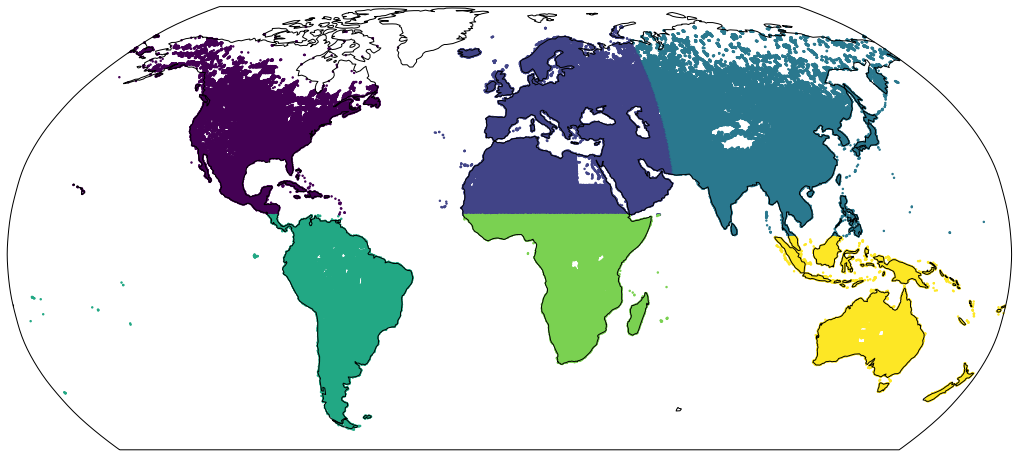

In [24]:
fig = plt.figure(figsize=(18, 18))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.scatter(
    latlonsdf_samp["lon"],
    latlonsdf_samp["lat"],
    transform=ccrs.PlateCarree(),
    s=2,
    c=latlonsdf_samp["samp"],
)

fig.savefig(
    save_dir / "continent_split.png",
    bbox_inches="tight",
)

### World R2s 

In [25]:
print("cross-validation R2s:")
for ix, task_name in enumerate(labels_to_run):
    r2_t = sklearn.metrics.r2_score(
        world_data["y_train"][:, ix], world_data["y_pred_train_cross_val"][:, ix]
    )
    r2_t_single = sklearn.metrics.r2_score(
        world_data_single["y_train"][:, ix],
        world_data_single["y_pred_train_cross_val"][:, ix],
    )
    print(f"{task_name}: {r2_t:.2f} ({r2_t_single:.2f} w/ global model)")

cross-validation R2s:
treecover: 0.85 (0.80 w/ global model)
elevation: 0.45 (0.26 w/ global model)
population: 0.62 (0.48 w/ global model)
nightlights: 0.49 (0.41 w/ global model)


### World Figures

/shares/lab/Datasets/Remote_Sensing/replication/mosaiks_IB/code/mosaiks/plotting/plot_world.py:163: RuntimeWarning: invalid value encountered in true_divide
  vals_grid = sums_grid / counts


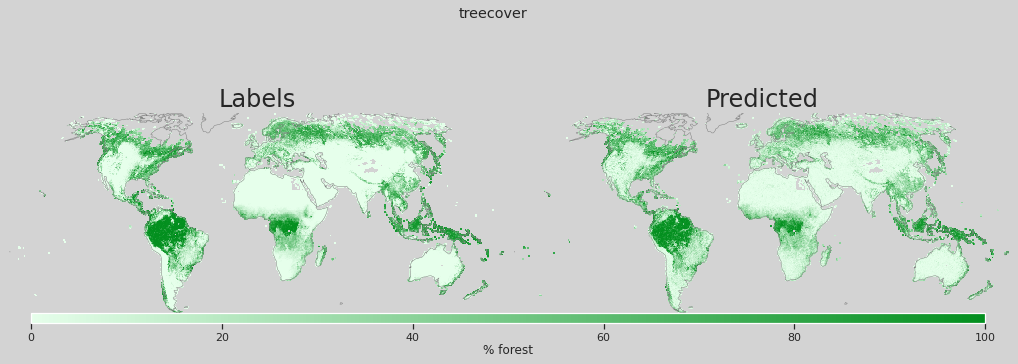

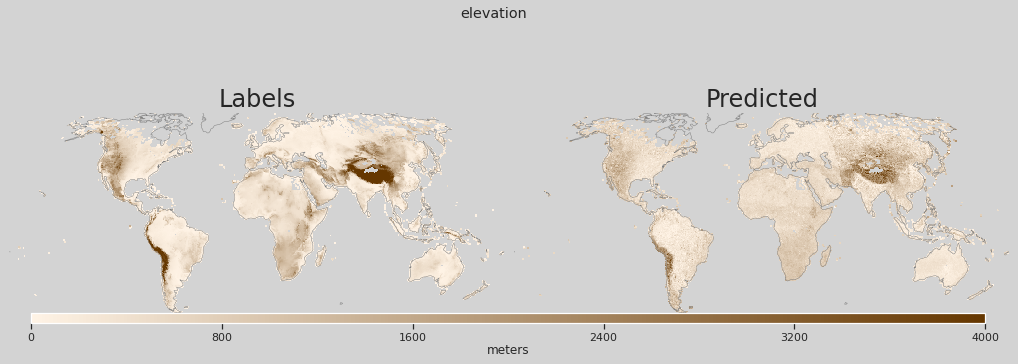

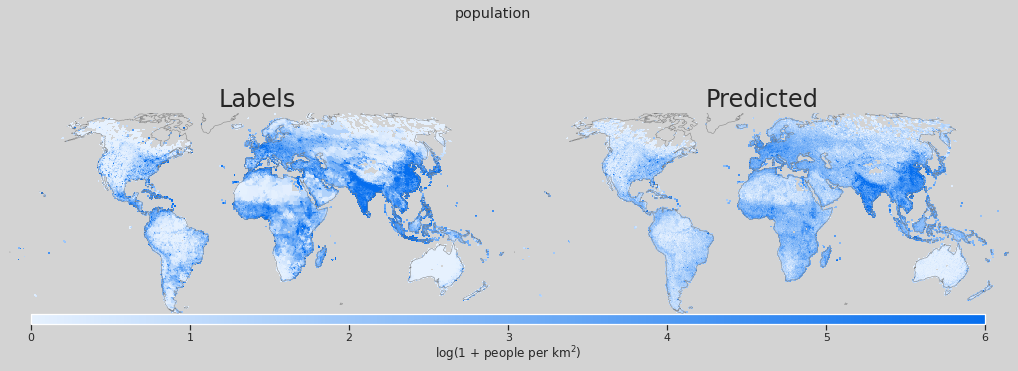

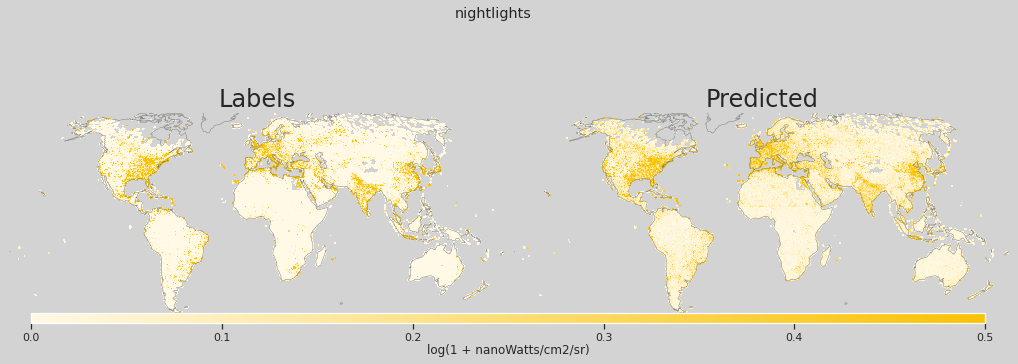

In [26]:
agg_scale_all = 0.5

# patch: https://github.com/SciTools/cartopy/issues/1151
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# make plot for each label
for label in labels_to_run:
    fig = pw.task_to_world_bin_plot(label, world_data, agg_scale=agg_scale_all)
    fig.suptitle(label)
    fig.savefig(
        save_dir / f"{label}_continent_model_globalclipping.pdf",
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
    )
    fig.show()